## Homework 6

### Clinton Alden

### Snow Hydrology

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
import pint

For this assignment, you will implement the two blowing snow sublimation models described above (the "flux-divergence" model and the "particle" model) for two blowing snow events, 12–14 December 2022 and 21-22 December 2022.

### Problem 1
For both case studies, plot time series of blowing snow flux from both FlowCapt sensors and w'ρᵥ' at 1 and 10 meters. (Variables in the SOS dataset are `SF_avg_1m_ue`, `SF_avg_2m_ue`, `w_h2o__1m_c`, `w_h2o__10m_c`). Explain how blowing snow and turbulent water vapor fluxes vary with height during the two case studies, and why.

In [16]:
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

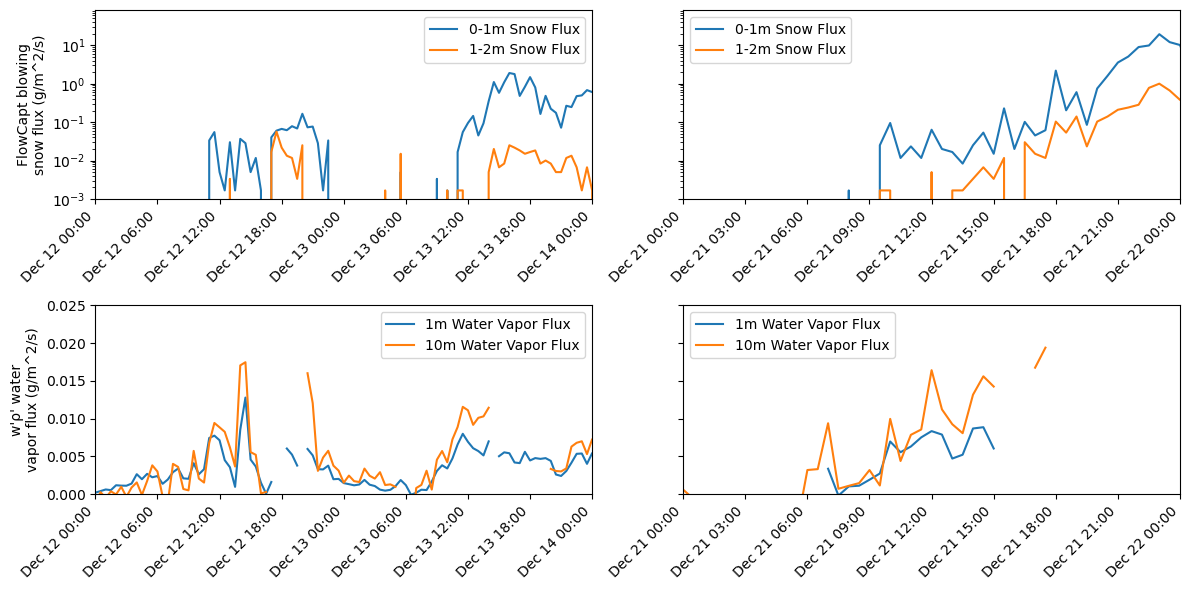

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharey='row')
fig.wspace = 1

ax[0, 0].plot(sos_dataset.time, sos_dataset['SF_avg_1m_ue'], label='0-1m Snow Flux')
ax[0, 0].plot(sos_dataset.time, sos_dataset['SF_avg_2m_ue'], label='1-2m Snow Flux')
ax[0, 0].legend()
ax[0, 0].set_xlabel("")
ax[0, 0].set_yscale("log")
ax[0, 0].set_xlim(dt.datetime(2022,12,12), dt.datetime(2022,12,14))
ax[0, 0].set_ylabel("FlowCapt blowing\nsnow flux (g/m^2/s)")

ax[0, 1].plot(sos_dataset.time, sos_dataset['SF_avg_1m_ue'], label='0-1m Snow Flux')
ax[0, 1].plot(sos_dataset.time, sos_dataset['SF_avg_2m_ue'], label='1-2m Snow Flux')
ax[0, 1].legend()
ax[0, 1].set_xlabel("")
ax[0, 1].set_yscale("log")
ax[0, 1].set_xlim(dt.datetime(2022,12,21), dt.datetime(2022,12,22))
# ax[0, 1].set_ylabel("FlowCapt blowing\nsnow flux (g/m^2/s)")

ax[1, 0].plot(sos_dataset.time, sos_dataset['w_h2o__1m_c'], label='1m Water Vapor Flux')
ax[1, 0].plot(sos_dataset.time, sos_dataset['w_h2o__10m_c'], label='10m Water Vapor Flux')
ax[1, 0].legend()
ax[1, 0].set_xlabel("")
ax[1, 0].set_xlim(dt.datetime(2022,12,12), dt.datetime(2022,12,14))
ax[1, 0].set_ylabel("w'ρ' water\nvapor flux (g/m^2/s)")
ax[1, 0].set_ylim(0, 0.025)

ax[1, 1].plot(sos_dataset.time, sos_dataset['w_h2o__1m_c'], label='1m Water Vapor Flux')
ax[1, 1].plot(sos_dataset.time, sos_dataset['w_h2o__10m_c'], label='10m Water Vapor Flux')
ax[1, 1].legend()
ax[1, 1].set_xlabel("")
# ax[1, 1].set_yscale("log")
ax[1, 1].set_xlim(dt.datetime(2022,12,21), dt.datetime(2022,12,22))
# ax[1, 1].set_ylim(0, 0.025)

date_format = mdates.DateFormatter('%b %d %H:%M')
for axes in ax.flat:
    axes.xaxis.set_major_formatter(date_format)
    plt.setp(axes.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()

#### Answer

Blowing snow fluxes are largest near the surface while turbulent water vapor fluxes were larger at 10m than 1m in both case studies. Blowing snow is higher near the surface because fewer snow grains can be lofted to greater heights as heavier grains fall back to the surface. As this some of this blowing snow sublimates, in increases the water vapor in the atmosphere. As one moves away from the surface, water vapor flux increases as there has been more sublimation than directly at the surface. We see this with the 10m turbulent water vapor fluxes that were larger than at 1m.

### Problem 2 Using the flux divergence model, calculate time series of $S_{flux}$ for the length of the two events. Using the particle model, calculate time series of $S_{particle, flux}$ for the length of the two events. Use the constants I provide above for the particle model. Choose your own value for snowflake/ice particle radius (r). For the two events, create a time series plot that includes lines for w'ρᵥ' at 1 meter, w'ρᵥ' at 10 meters, $S_{flux}$, and $S_{particle, flux}$.

In [28]:
def particle_sublimation_rate(T, q_s, q, r, lambda_s, k_T, Nu, M_w, R_g, k_v, Sh):
    """ Estimate particle sublimaton rate (g/s) using the Thorpe-Mason model.
        See Thorpe and Mason, 1966, their Equation 10 (the first form, on the left side)
        T - ambient air temperature (K)
        q_s - saturation absolute humidity (g/m^3)
        q - ambient air absolute humidity (g/m^3)
        r - ice particle radius (m)
        lambda_s - latent heat of sublimation (J/kg)
        k_T - thermal conductivity for air (W/m/K)
        Nu - Nusselt number, typical values for snowdrifts are 2--10 (dimensionless)
        M_w - molecular weight of water vapour
        R_g - universal gas constant (J/mol/K)
        k_v - molecular diffusivity of h2o vapour in air (m2 s−1)
        Sh - Sherwood number, typical values for snowdrifts are 2--10 (dimensionless)
    """
    dm_dt = (
        2*np.pi*r* (q/q_s - 1)
    ) / (
        (lambda_s/(k_T * T)) * (1 / Nu) * (lambda_s * M_w / (R_g * T)) + 1/(k_v * q_s * Sh)
    ).to_base_units()
    return dm_dt

lambda_s = 2838000*units("J/kg")# latent heat of sublimation (J kg−1)
k_T = 0.02288*units("W/m/K")    # thermal conductivity air, for air at -10˚C  (W/m/K)
Nu = 8                          # Nusselt number, typical values for snowdrifts: 2 - 10
M_w = 0.018*units("kg/mol")     # molecular weight of water vapour (kg/mol)
R_g = 8.3145*units("J/mol/K")   # universal gas constant (J mol−1 K−1)
k_v = 24.9*1e-6*units("m^2/s")  # molecular diffusivity of h2o vapour in air (m2 s−1)
Sh = Nu

T = (sos_dataset['T_1m_c'].values + 273.15)*units("kelvin")
from metpy.calc import mixing_ratio_from_relative_humidity
mr_sat = mixing_ratio_from_relative_humidity(sos_dataset['P_10m_c'].values * units("millibars"), T, 1)
q_s = (mr_sat * sos_dataset['dryairdensity_1m_c'].values*units("kg/m^3"))
q = ((sos_dataset['mixingratio_1m_c'].values*units("g/g"))*(sos_dataset['dryairdensity_1m_c'].values*units("kg/m^3")))
r = 0.0005*units("m")

dm_dt = particle_sublimation_rate(T, q_s, q, r, lambda_s, k_T, Nu, M_w, R_g, k_v, Sh)


bs_mass_concentration = (sos_dataset['SF_avg_1m_ue'].values*units("g/m^2/s"))/(sos_dataset['u_1m_ue'].values*units("m/s"))
snowgrain_mass = (4/3)*np.pi*r**3*(917*units("kg/m^3"))
particle_density = bs_mass_concentration/snowgrain_mass
bs_sub_rate = dm_dt * particle_density
S_particle_flux = -bs_sub_rate*(1*units("m"))

In [29]:
S_particle_flux

Magnitude,[0.0 0.0 0.0 ... 0.0 0.0 0.0]
Units,gram/(meter2 second)


In [30]:
# S_flux
s_flux = ((sos_dataset['w_h2o__10m_c'] - sos_dataset['w_h2o__1m_c'])/(10-1)) * units("g/m^3/s")

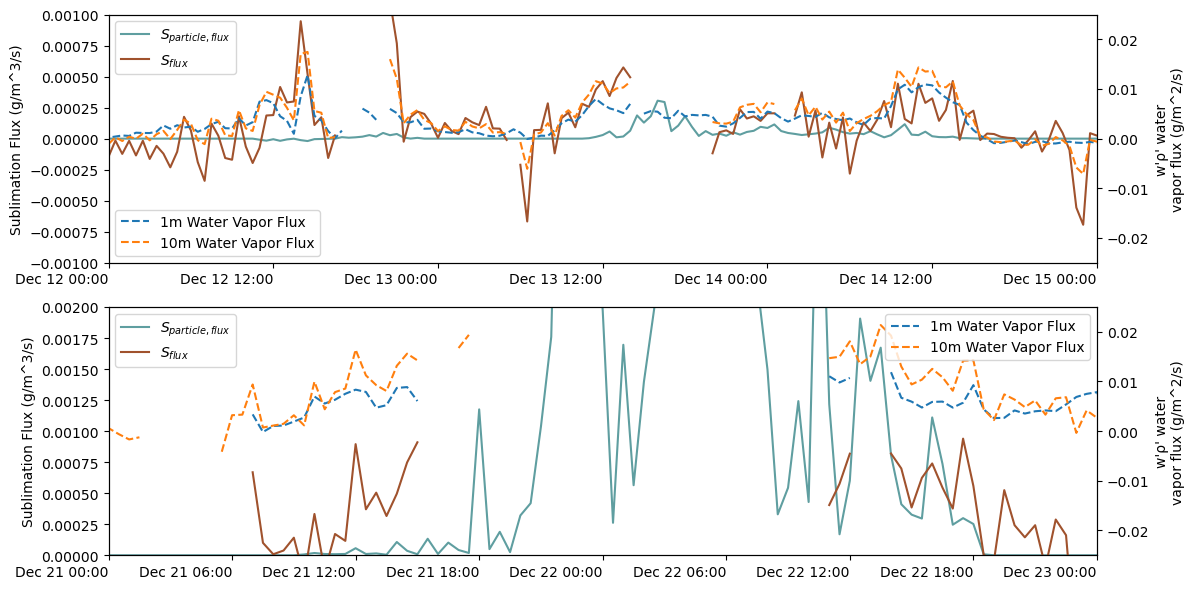

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

ax2 = ax[0].twinx()
ax2.plot(sos_dataset.time, sos_dataset['w_h2o__1m_c'], label='1m Water Vapor Flux', ls='--')
ax2.plot(sos_dataset.time, sos_dataset['w_h2o__10m_c'], label='10m Water Vapor Flux', ls='--')
ax[0].plot(sos_dataset.time, S_particle_flux.magnitude, label='$S_{particle, flux}$', c='cadetblue')
ax[0].plot(sos_dataset.time, s_flux, label='$S_{flux}$', c='sienna')
ax[0].legend(loc='upper left')
ax2.legend()
ax[0].set_xlabel("")
# ax[0].set_yscale("log")
ax[0].set_xlim(dt.datetime(2022,12,12), dt.datetime(2022,12,15))
ax[0].set_ylabel("Sublimation Flux (g/m^3/s)")
ax2.set_ylabel("w'ρ' water\nvapor flux (g/m^2/s)")
ax[0].set_ylim(-0.001, 0.001)
ax2.set_ylim(-0.025, 0.025)




ax3 = ax[1].twinx()
ax3.plot(sos_dataset.time, sos_dataset['w_h2o__1m_c'], label='1m Water Vapor Flux', ls='--')
ax3.plot(sos_dataset.time, sos_dataset['w_h2o__10m_c'], label='10m Water Vapor Flux', ls='--')
ax[1].plot(sos_dataset.time, S_particle_flux.magnitude, label='$S_{particle, flux}$', c='cadetblue')
ax[1].plot(sos_dataset.time, s_flux, label='$S_{flux}$', c='sienna')
ax[1].legend(loc='upper left')
ax3.legend(loc='upper right')
ax[1].set_xlabel("")
# ax[1].set_yscale("log")
ax[1].set_xlim(dt.datetime(2022,12,21), dt.datetime(2022,12,23))
ax3.set_ylabel("w'ρ' water\nvapor flux (g/m^2/s)")
ax[1].set_ylabel("Sublimation Flux (g/m^3/s)")
ax[1].set_ylim(0, 0.002)
ax3.set_ylim(-0.025, 0.025)

date_format = mdates.DateFormatter('%b %d %H:%M')
for axes in ax.flat:
    axes.xaxis.set_major_formatter(date_format)
    plt.setp(axes.xaxis.get_majorticklabels(), ha='right')

plt.tight_layout()

#### Problem 2.1

With respect to your plots from Question 2, answer the following questions. What do the two model results tell you about blowing snow sublimation during the events? Which of the two models seems to produce more reasonable results? Which model do you believe more?

#### Answer
In the first event, the sign of sublimation and water vapor flux did not always track together. Near the beginning of the event, sublimation flux was negative (deposition?) while observing positive water vapor flux. This changed around 1200 on 12 December where their magnitudes and signs tracked togther well. In the second event, the water vapor flux trend followed the sublimation flux trend from the flux divergence model quite well. This would indicate that blowing snow was contributing to water vapor flux into the atmosphere. 

The flux divergence model seems to perform better than the particle flux model. I've checked all the units multiple times but the results from the particle flux model do not make much sense here. The values in this model are close to 0 for most of each time period and then go negative near the end of both time series. Intuitively, this does not make sense. If we measure a positive water vapor flux from 1m to 10m with blowing snow, the particle flux model should not be suggesting deposition.

#### Problem 2.2

Describe the shortcomings of the flux divergence model, as implemented here.

#### Answer

The main shortcoming of the flux divergence model as implemented here is that we are measuring water vapor flux at only two levels and comparing. Perhaps the peak in water vapor flux could be higher or lower than 10m and we could be missing some water vapor flux. This also to some extent ignores other environmental conditions. There may evaporation happening from a nearby creek or river that could also contribute. In this simplified model, we assume all changes in water vapor flux between 1m and 10m is due to sublimation which may not be entirely true. That being said, I prefer the flux divergence model over the Thorpe-Mason Particle model for representing sublimation.

#### Problem 2.3

Describe the shortcomings of the particle model, as implemented here. Include in your answer: your final choice for particle radius and how that compares to measurements of particle radii in the figure above.

#### Answer

The particle model as implemented here is parameterizing a number of its inputs. Each parameterization is an approximation and introduces potential for error. The Nusselt number, Sherwood number, thermal conductivity, molecular diffusivity, and snow particle radii are all paramaterized at fixed values. Obviously, this is a necessary step given we can't measure all of these quantities perfectly for every timestep but they do introduce the potential for error. I ultimately chose a blowing snow particle size of 0.5mm. This value lines up well with snow grains I have previously observed in wind slabs and with the measurements provided in the assignment.